In [2]:
import csv 
# from fpdf import FPDF
# !pip install fasttext-langdetect
# from ftlangdetect import detect
import seaborn as sns
import matplotlib.pyplot as plt

# CSV to PDF
### No split perfomed

Converting .csv file to pretty .pdf:  

| REGION_NAME | BUSINESS_AREA_NAME | NarrativeTitle                   | NarrativeText |
| ----------- | ------------------ | -------------------------------- | ------------- |
| EAPR        | Cambodia           | Lessons Learned and Innovations  | sdfhjsdf      |
| EAPR        | China              | Lessons Learned and Innovat ions | aslkdgvj      |  

PDF:

Year - 2022, Country - Combodia   
Lessons learned and Innovations for the country Cambodia in the region EAPR for the year 2022 were as follows:  
sdfkljsdf  

Year - 2022, Country - China  
Lessons learned and Innovations for the country China in the region EAPR for the year 2022 were as follows:  
aslkdgvj


In [52]:
in_file_path = '../Lessons learnt Narrative insights/RAM docs/'
out_file_path = '../Lessons learnt Narrative insights/transformed docs/no split/'
file_name = 'RAM3 End-Year Summary Narrative Analysis '
file_years = ['2018','2019','2020','2021','2022']
token_count_dict = {'1 split':0, '2 splits':0 ,'2+ splits':0} 
one_split_narrs, two_split_narrs = [], []

for file_year in file_years:
    with open(in_file_path+file_name+file_year+'.csv','r') as file_in:
        
        reader = csv.reader(file_in, delimiter=',')
        next(reader,None) # skip header here.
        
        with open(out_file_path+file_name+file_year+'.txt','w') as file_out:
            count  = 0
            country_name = None
            for row in reader:
                if row :
                    if row[0] == 'HQ': break
                
                    else:
                        country_name = row[1] 
                        h1 = f'\n\nYear - {file_year}, Country - {country_name}.\n'
                        h2 = f'Lessons learned and Innovations for the country {country_name} in the region EAPR for the year {file_year} were as follows:\n'
                        text = row[3]
                        # '''uncomment the following before running'''
                        # text = text.replace('\n',' ')
                        # is_en = detect(text = text, low_memory = True)
                        # if is_en['lang'] =='en' and is_en['score']>=0.85:

                        #     file_out.write(h1)
                        #     file_out.write(h2)
                        #     file_out.write(row[3])
# '''Expermintal code to save as pdf. '''
            #             pdf.add_page()
            #             pdf.cell(200, 10, txt = h1, ln = 1, align = 'L')
            #             pdf.cell(200, 10, txt = h2, ln = 1, align = 'L')
            #             pdf.cell(200, 10, txt = text, ln = 1, align = 'L')
            # pdf.output(file_path+file_name+file_year+".pdf")   
                        '''check count of tokens in each narrative and plot'''
                        token_count = len(text.split()) * 1.3 # avg. tokens per word.
                        if token_count // 1024 == 0: 
                            token_count_dict['1 split'] += 1 
                            one_split_narrs.append([file_year,country_name])
                        elif token_count // 1024 == 1: 
                            token_count_dict['2 splits'] += 1 
                            two_split_narrs.append([file_year,country_name])
                        else: token_count_dict['2+ splits'] += 1 
                        # y_axis.append(token_count)
                        # x_axis.append(i)            

[Text(0, 0, '98'), Text(0, 0, '433'), Text(0, 0, '56')]

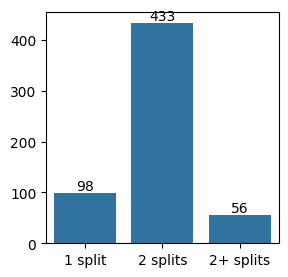

In [53]:
fig,ax = plt.subplots(figsize = (3,3))
sns.barplot(data = token_count_dict)
ax.bar_label(ax.containers[0], fontsize=10)

### Observations:  
* The Azure OpenAI API will divide the docs in chunks of 1024 (max if not specified).
* Most of the docs will get split into 2 chunks. 
* Total narrs = 587. En narrs = 554.  
* Most docs are having more than 2/2+ splits. 
    * That means context that I added in the begining will not be carry forwarded.  
    * In fact, one split might contain more than one year,country data, messing up the context.

## TODO:  
* (DONE) Remove non-eng narratives.
* (CANCELLED) PDF convertion fails at \u2018 character.


# Document splitting

In [1]:
import csv 
import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings


In [2]:
in_file_path = '../Lessons learnt Narrative insights/RAM docs/'
out_file_path = '../Lessons learnt Narrative insights/transformed docs/with split/'
file_name = 'RAM3 End-Year Summary Narrative Analysis '
file_years = ['2018','2019','2020','2021','2022']

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
# Set a really small chunk size, just to show.
chunk_size = 500,
chunk_overlap  = 20,
length_function = len,
add_start_index = True,
)

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


for file_year in tqdm.tqdm(file_years, desc='year loop', position=0):
    with open(in_file_path+file_name+file_year+'.csv','r') as file_in:
        
        reader = csv.reader(file_in, delimiter=',')
        next(reader,None) # skip header here.
        
        country_name = None
        for row in tqdm.tqdm(reader, desc= 'csv.reader loop', position=1):
            if not row : break
            if row[0] == 'HQ': break

            region_name = row[0]
            country_name = row[1] 
            # h1 = f'\n\nYear - {file_year}, Country - {country_name}.\n'
            # h2 = f'Lessons learned and Innovations for the country {country_name} in the region EAPR for the year {file_year} were as follows:\n'
            text = row[3]
        
            """uncomment the following before running"""
            # text = text.replace('\n',' ')
            # is_en = detect(text = text, low_memory = True)
            # if is_en['lang'] =='en' and is_en['score']>=0.85:
            metadata = {
                'year' : file_year,
                'region_name' : region_name,
                'country_name' : country_name
            }
            splits = text_splitter.create_documents([text], metadatas=[metadata])
            db = Chroma.from_documents(splits, embedding_function, persist_directory="./chroma_db")
            
            # for i, split in enumerate(splits):
            #     print(type(split),split)
            #     db = Chroma.from_documents(split, embedding_function, persist_directory="./chroma_db", ids= f'{file_year} {country_name} {i+1}' )
                # with open(out_file_path+file_name+file_year+str(i+1)+'.txt','w') as file_out:
                #     file_out.write(split)
                    

csv.reader loop: 128it [04:19,  2.03s/it] ?it/s]
csv.reader loop: 128it [02:54,  1.36s/it]:18, 259.60s/it]
csv.reader loop: 135it [03:13,  1.43s/it]:28, 209.65s/it]
csv.reader loop: 135it [03:25,  1.53s/it]:44, 202.21s/it]
csv.reader loop: 61it [01:20,  1.31s/it]3:23, 203.68s/it]
year loop: 100%|██████████| 5/5 [15:13<00:00, 182.72s/it]


In [8]:
retriever = db.as_retriever(persist_directory="./chroma_db", search_type="mmr")
docs = retriever.get_relevant_documents("What was UNICEF's role in building scalable business model for innovations in humanitarian setting?")

for doc in docs:
    print(doc.metadata, doc.page_content)

{'country_name': 'Burundi', 'region_name': 'ESAR', 'start_index': 483, 'year': '2020'} as well as access to its markets, while UNICEF provided financial assets, facilitated stakeholder dialogues and did the advocacy work. This dynamic suggests that partnerships between humanitarian/development organizations and private enterprises could play an important role in achieving a set of common objectives. Despite having different interests and objectives, by pooling complementary capacities and resources, the collaboration had the desired outcome. Hence UNICEF is exploring other models
{'country_name': 'Jamaica', 'region_name': 'LACR', 'start_index': 1, 'year': '2018'} Establish the grounds for scalability and sustainability of UNICEF interventions
{'country_name': 'Malaysia', 'region_name': 'EAPR', 'start_index': 2151, 'year': '2021'} model for integrating innovation into UNICEF programming.
{'country_name': 'Ethiopia', 'region_name': 'ESAR', 'start_index': 477, 'year': '2018'} due to struc

In [10]:
retriever = db.as_retriever(search_kwargs={"k": 5})
docs = retriever.get_relevant_documents("What was UNICEF's role in building scalable business model for innovations in humanitarian setting?")

for doc in docs:
    print(doc.metadata, doc.page_content)

{'country_name': 'Burundi', 'region_name': 'ESAR', 'start_index': 483, 'year': '2020'} as well as access to its markets, while UNICEF provided financial assets, facilitated stakeholder dialogues and did the advocacy work. This dynamic suggests that partnerships between humanitarian/development organizations and private enterprises could play an important role in achieving a set of common objectives. Despite having different interests and objectives, by pooling complementary capacities and resources, the collaboration had the desired outcome. Hence UNICEF is exploring other models
{'country_name': 'Jamaica', 'region_name': 'LACR', 'start_index': 1, 'year': '2018'} Establish the grounds for scalability and sustainability of UNICEF interventions
{'country_name': 'Malaysia', 'region_name': 'EAPR', 'start_index': 2151, 'year': '2021'} model for integrating innovation into UNICEF programming.
{'country_name': 'Zambia', 'region_name': 'ESAR', 'start_index': 3804, 'year': '2019'} approach). UN

In [11]:
retriever = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": .5})
docs = retriever.get_relevant_documents("What was UNICEF's role in building scalable business model for innovations in humanitarian setting?")

for doc in docs:
    print(doc.metadata, doc.page_content)

{'country_name': 'Burundi', 'region_name': 'ESAR', 'start_index': 483, 'year': '2020'} as well as access to its markets, while UNICEF provided financial assets, facilitated stakeholder dialogues and did the advocacy work. This dynamic suggests that partnerships between humanitarian/development organizations and private enterprises could play an important role in achieving a set of common objectives. Despite having different interests and objectives, by pooling complementary capacities and resources, the collaboration had the desired outcome. Hence UNICEF is exploring other models
{'country_name': 'Jamaica', 'region_name': 'LACR', 'start_index': 1, 'year': '2018'} Establish the grounds for scalability and sustainability of UNICEF interventions
{'country_name': 'Malaysia', 'region_name': 'EAPR', 'start_index': 2151, 'year': '2021'} model for integrating innovation into UNICEF programming.
{'country_name': 'Zambia', 'region_name': 'ESAR', 'start_index': 3804, 'year': '2019'} approach). UN

### Observations:  
* creating vector db took ~18 mins.
* Vector db size = ~60-90 MB.
* Brundi, Jamaica is again at the top like we got in AI playground.

## TODO:  
* (DONE) add metadata to splits. 
    * Why? metadata is useful only when LLM is being used. Can our retriver make use of this metadata?
* improve document splitting.
* count docs retrived per year, per country, per region.